## Model Stellar Spectra with 5 Stellar Parameters

In [1]:
%load_ext autoreload
%autoreload 2

### Import

In [2]:
import os
import nbi
import smart
import torch
import pickle
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing.resource_tracker")

### Set path

In [3]:
data_path = '/stow/weilingfeng/data/apogee/'
model_path = f'{data_path}/nbi_5_params'

### Read Data

In [5]:
# Read real spectra
with open(f'{data_path}/real_spectra.pkl', 'rb') as file:
    real_spectra = pickle.load(file)

wave = real_spectra['wave']
flux = real_spectra['flux']
params = np.array([real_spectra[_] for _ in ['Teff', 'HRV', 'Vsini', 'logg', '[M/H]']]).T

In [6]:
params.shape

(14334, 5)

In [7]:
def normalize(wave, flux, filter_size=500):
    """
    Normalize the continuum by fitting a linear slope to local max over a range of model fluxes, parameterized by filter_size.
    """
    max_list = []
    for i in range(int(len(wave)/filter_size)):
        max_list.append(max(flux[i*filter_size:(i+1)*filter_size]))

    x, y = wave[[i*filter_size+int(filter_size/2) for i in range(int(len(wave)/500))]], max_list
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)

    flux = flux/p(wave)
    return flux

### Define noise

In [8]:
def noise(x, y):
    rand = np.random.normal(0, 1, size=x.shape[0])

    # let's say x_err is drawn from [0, 0.05]
    x_err = np.random.uniform() * 0.05
    x_noise = x + rand * x_err * x
    return x_noise, y

### Plot an example spectra

In [93]:
flux[0]

masked_array(data=[0.8424316241053823, 0.8723022960960084,
                   0.9392146880989212, ..., 0.9668625035651253,
                   0.9842578853571617, 0.9742423445428081],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

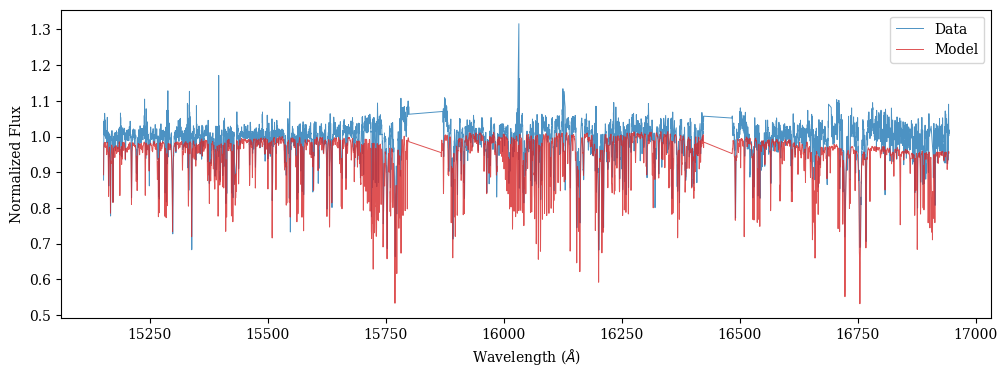

In [14]:
test_idx = 0
instrument = 'apogee'
order = 'all'
modelset = 'phoenix-aces-agss-cond-2011'

user_path = os.path.expanduser('~')
data_path = f'{user_path}/ML/Group7-Project/data'
spec_path = f'{data_path}/spec'
apogee_type = 'aspcap'
prefix='aspcapStar'

spec = smart.Spectrum(
    name=real_spectra['ID'][0],
    path=f"{spec_path}/{prefix}-dr17-{real_spectra['ID'][test_idx]}.fits", 
    instrument=instrument, 
    apply_sigma_mask=True, 
    datatype=apogee_type, 
    applytell=True
)
spec.flux = np.interp(wave, spec.wave, spec.flux)
spec.wave = wave
spec.flux /= np.median(spec.flux)

model = smart.makeModel(
    teff=real_spectra['Teff'][test_idx], 
    logg=real_spectra['logg'][test_idx], 
    rv=real_spectra['HRV'][test_idx],
    vsini=real_spectra['Vsini'][test_idx],
    metal=real_spectra['[M/H]'][test_idx],
    instrument=instrument, 
    order=order, 
    modelset=modelset, 
    lsf=real_spectra['lsf'], 
    xlsf=real_spectra['xlsf']    
)

model.flux = np.interp(wave, model.wave, model.flux)
model.wave = wave

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(spec.wave, spec.flux, lw=0.7, alpha=0.8, color='C0', label='Data')
# ax.plot(wave, noise(flux[test_idx], params[test_idx])[0], lw=0.7, alpha=0.8, label='Data With Noise', zorder=1)
ax.plot(model.wave, model.flux, lw=0.7, alpha=0.8, color='C3', label='Model')
ax.legend()
ax.set_xlabel('Wavelength ($\AA$)')
ax.set_ylabel('Normalized Flux')
plt.show()

### Set prior

In [15]:
prior = {
    'teff':     uniform(loc=2300, scale=7000-2300),  # U(2300, 7000) K
    'rv':       uniform(loc=-200, scale=200-(-200)), # U(-200, 200) km/s
    'vsini':    uniform(loc=0, scale=100),           # U(0, 100) km/s
    'logg':     uniform(loc=2.5, scale=6-2.5),       # U(2.5, 6)
    'metal':    uniform(loc=-2.12, scale=0.5+2.12)   # U(-2.12, 0.5)
}

labels = list(prior.keys())
priors = [prior[k] for k in labels]

### Setup nbi and train

In [16]:
torch.cuda.empty_cache()
model_path = '/stow/weilingfeng/data/apogee/nbi_5_params'
# Read existing model
with open(f'{model_path}/best_model_path.txt', 'r') as file:
    best_model = file.read()

engine = nbi.NBI(
    state_dict=best_model,
    priors=priors,
    labels=labels,
    device='cuda',
    path=model_path,
    n_jobs=16
)

### Predict

In [18]:
test = engine.sample(spec.flux, n=5)
# logprior = engine.log_prior(test)
y = test
log_prob = np.zeros(len(y))
for i, prior in enumerate(engine.prior):
    print(labels[i])
    print(y[:, i])
    print(prior.logpdf(y[:, i]))
    print()
    log_prob += prior.logpdf(y[:, i])

teff
[3926.7087 3981.6138 3963.2495 4056.417  4008.3948]
[-8.45531779 -8.45531779 -8.45531779 -8.45531779 -8.45531779]

rv
[-48.888683 -45.47446  -44.452366 -33.552197 -40.88453 ]
[-5.99146455 -5.99146455 -5.99146455 -5.99146455 -5.99146455]

vsini
[-0.75522995 -2.724636   -1.7473183  -5.65292    -1.2819939 ]
[-inf -inf -inf -inf -inf]

logg
[4.9028654 4.925665  4.804299  4.8926263 5.00173  ]
[-1.25276297 -1.25276297 -1.25276297 -1.25276297 -1.25276297]

metal
[-0.9622438 -0.9814577 -1.0339081 -1.0279443 -1.0235758]
[-0.96317432 -0.96317432 -0.96317432 -0.96317432 -0.96317432]



In [19]:
log_prob

array([-inf, -inf, -inf, -inf, -inf])

In [53]:
np.random.seed(0)

# draw random parameter from prior
dim = len(wave)
idx = 3
y_pred = engine.predict(
    np.interp(wave, wave[~flux[idx].mask], flux[idx][~flux[idx].mask]), 
    y_true=params[idx], 
    n_samples=12800, 
    corner=True, 
    corner_reweight=True, 
    seed=0
)

Samples outside prior N = 12800
surrogate posterior
x=[0.88526797 0.94410098 0.99154299 ... 1.06104004 1.02702999 1.02941   ]
ys=[]


AssertionError: I don't believe that you want more dimensions than samples!

### Optional: simulator

Requires the installation of [`smart`](https://github.com/chihchunhsu/smart)

In [ ]:
import smart
from matplotlib.lines import Line2D

# simulator
instrument = 'apogee'
order = 'all'
modelset = 'phoenix-aces-agss-cond-2011'
lsf  = simulated_spectra['lsf']
xlsf = simulated_spectra['xlsf']

def simulate_spectra(params):
    teff, rv, vsini, logg, metal = params
    model = smart.makeModel(teff=teff, rv=rv, vsini=vsini, logg=logg, metal=metal, instrument=instrument, order=order, modelset=modelset, lsf=lsf, xlsf=xlsf)
    model.flux = np.array(smart.integralResample(xh=model.wave, yh=model.flux, xl=wave))
    return model.flux


y_true = [var.rvs(1)[0] for var in priors]
x_err = 0.05
x_obs = simulate_spectra(y_true) + np.random.normal(size=len(wave)) * x_err

dim = len(wave)
engine.simulator = simulate_spectra
engine.n_jobs = 16
y_pred, weights = engine.predict(x_obs, x_err=np.zeros_like(x_obs)+0.05, y_true=y_true, n_samples=5120, corner=True, corner_reweight=True, seed=0)
plt.show()

In [ ]:
y_pred_med = np.median(y_pred, axis=0)


def plot_spectrum(wave, obs_spec, model_spec, lw=0.7, alpha=0.8, save_path=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax1.plot(wave, obs_spec, color='C0', alpha=alpha, lw=lw)
    ax1.plot(wave, model_spec, color='C3', alpha=alpha, lw=lw)
    ax2.plot(wave, obs_spec - model_spec, color='C7', alpha=alpha, lw=lw*0.8)

    ax1.minorticks_on()
    ax1.xaxis.tick_top()
    ax1.tick_params(axis='both', labelsize=12, labeltop=False)  # don't put tick labels at the top
    ax1.set_ylabel('Normalized Flux', fontsize=15)
    h1, l1 = ax1.get_legend_handles_labels()

    ax2.axhline(y=0, color='k', linestyle='--', dashes=(8, 2), alpha=alpha, lw=lw)
    ax2.minorticks_on()
    ax2.tick_params(axis='both', labelsize=12)
    ax2.set_xlabel(r'$\lambda$ ($\AA$)', fontsize=15)
    ax2.set_ylabel('Residual', fontsize=15)
    h2, l2 = ax2.get_legend_handles_labels()

    legend_elements = [
        Line2D([], [], color='C0', alpha=alpha, lw=1.2, label='Data'),
        Line2D([], [], color='C3', lw=1.2, label='Model'),
        Line2D([], [], color='C7', alpha=alpha, lw=1.2, label='Residual')
    ]

    ax2.legend(handles=legend_elements, frameon=True, loc='lower left', bbox_to_anchor=(1, -0.08), fontsize=12, borderpad=0.5)
    fig.align_ylabels((ax1, ax2))
    # ax1.set_title(f'APOGEE {apogee_id}, Teff={teff:.2f}±{e_teff:.2}, RV={rv:.2f}±{e_rv:.2f}, vsini={vsini:.2f}')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


plot_spectrum(wave, x_obs, simulate_spectra(y_pred_med), save_path='/home/weilingfeng/ML/Group7-Project/figure/Model Spectrum.pdf')